In [34]:
#pip install fastparquet <- needs to be installed first time running

In [35]:
#pip install pyarrow

In [36]:
import pandas as pd
from matplotlib import pyplot as plt

In [37]:
import sys  
sys.path.insert(0, '../misc')
from extract_func import extract_func

In [38]:
df_org_data = pd.read_csv('../data/data_raw.csv')

# Preprocessing dataframe #

## Introduction

This notebook was used to preprocess the raw covid data.csv file to generate a dataframe appropiate for clustering. The covid data.csv file has been splitt up into two dataframes, to avoid unecessary high dimennsion. All duplicate information such as Continent, Latitude, Longitude, Average temperature per year etc. has been removed from the resulting dataframes in this notebook, and rather stored in lookup table, see misc->generating_lookup_table.  

Chocen start date: 2020-03-01, end date: 2020-09-17

## Formating ##

Original dataframe:

In [39]:
df_org_data.head(4)

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests,Cases,Deaths
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2019-12-31,NaN,0.0,0.0
1,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-01,NaN,0.0,0.0
2,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-02,NaN,0.0,0.0
3,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-03,NaN,0.0,0.0


Copy of original dataframe:

In [40]:
df_mod = df_org_data.copy()

Removing all irrelevant columns:

In [41]:
df_mod.drop(['Continent', 'Latitude', 'Longitude', 'Average temperature per year', 'Hospital beds per 1000 people', 'Medical doctors per 1000 people', 'GDP/Capita','Population', 'Median age', 'Population aged 65 and over (%)','Daily tests', 'Deaths'], axis=1, inplace=True)

#### Continues time series

Observe that Algeria misses data for 2020-03-03, the "Date" column jumps from 2020-03-02 -> 2020-03-04. Method implemented below to correct this:
<br>
1). Add NaN value for all days betweenn start date and end date where day origianl was missing. 
<br>
2). Convert all NaN values to zero
<br>
3). Use forward fill to convert all zeros appearing after first detected case to most recent past value

In [42]:
df_mod[61:64]

,Entity,Date,Cases
61,Algeria,2020-03-01,3.0
62,Algeria,2020-03-02,3.0
63,Algeria,2020-03-04,5.0


Converting df_mod to use "Date" column as index:

In [43]:
df_mod.set_index('Date', inplace=True)

In [44]:
df_mod.index = pd.to_datetime(df_mod.index)

Creating referance DatetimeIndex dataframe with desired start and end date

In [45]:
df_index = pd.date_range(start='3/1/2020', end='09/17/2020')

In [46]:
df_index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17'],
              dtype='datetime64[ns]', length=201, freq='D')

In [47]:
df_empty_index = pd.DataFrame(columns=[], index=df_index)

In [48]:
df_empty_index.head(4)

""
2020-03-01
2020-03-02
2020-03-03
2020-03-04


Converting df_mod to desired format with country as column name and Date as index:

In [49]:
countries = df_mod['Entity'].unique()

In [50]:
frame={}
for country in countries:
    temp_segment = df_mod[df_mod['Entity'] == country].copy()
    frame.update({country: temp_segment['Cases']})
df_temp = pd.concat(frame, join='outer', axis=1)

In [51]:
df_temp.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2020-01-01,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2020-01-02,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2020-01-03,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN


Joining df_temp with df_empty_index (containg desired index) to achive desired index start, end and interval in df_temp:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

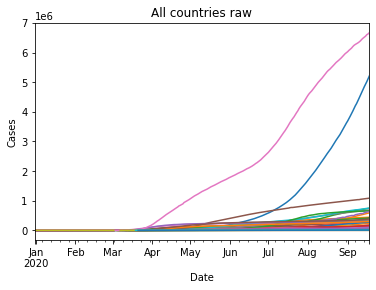

In [53]:
#NYYYYYYYYYYYYYY
plt.figure()
df_temp.plot(legend='')
plt.title("All countries raw")
plt.ylabel('Cases')


In [90]:
outlier_countries_list

['Spain',
 'Luxembourg',
 'Portugal',
 'Ecuador',
 'Italy',
 'Uganda',
 'Lithuania',
 'France']

Text(0.5, 0, 'Month')

<Figure size 432x288 with 0 Axes>

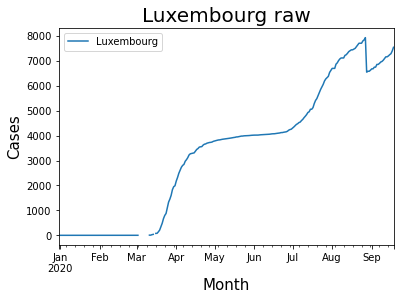

In [98]:
plt.figure()
df_temp.plot(y=['Luxembourg'])
plt.title('Luxembourg raw', fontsize=20)
plt.ylabel('Cases', fontsize=15)
plt.xlabel('Month', fontsize=15)

Text(0.5, 0, 'Month')

<Figure size 432x288 with 0 Axes>

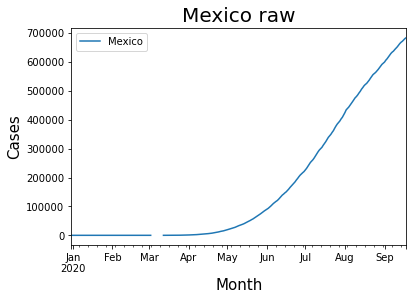

In [88]:
plt.figure()
df_temp.plot(y=['Mexico'])
plt.title('Mexico raw', fontsize=20)
plt.ylabel('Cases', fontsize=15)
plt.xlabel('Month', fontsize=15)

In [56]:
df_res = df_empty_index.join(df_temp)

In [57]:
df_res.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,3.0,NaN,26.0,10.0,41.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,21.0,42.0,69.0,NaN,16.0,NaN,NaN
2020-03-02,3.0,NaN,29.0,14.0,47.0,NaN,1.0,19.0,NaN,NaN,...,NaN,NaN,NaN,21.0,47.0,89.0,NaN,16.0,NaN,NaN
2020-03-03,NaN,NaN,33.0,18.0,NaN,NaN,NaN,38.0,NaN,NaN,...,NaN,NaN,NaN,NaN,69.0,103.0,NaN,NaN,NaN,NaN
2020-03-04,5.0,1.0,41.0,24.0,49.0,NaN,4.0,72.0,NaN,NaN,...,NaN,NaN,1.0,27.0,109.0,125.0,NaN,NaN,NaN,NaN


Replace all NaN values with zero:

In [58]:
df_res.fillna(0, inplace=True)

In [59]:
df_res.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,3.0,0.0,26.0,10.0,41.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,21.0,42.0,69.0,0.0,16.0,0.0,0.0
2020-03-02,3.0,0.0,29.0,14.0,47.0,0.0,1.0,19.0,0.0,0.0,...,0.0,0.0,0.0,21.0,47.0,89.0,0.0,16.0,0.0,0.0
2020-03-03,0.0,0.0,33.0,18.0,0.0,0.0,0.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,69.0,103.0,0.0,0.0,0.0,0.0
2020-03-04,5.0,1.0,41.0,24.0,49.0,0.0,4.0,72.0,0.0,0.0,...,0.0,0.0,1.0,27.0,109.0,125.0,0.0,0.0,0.0,0.0


Fill all zero values that appear post a value greater than zero with most recent past value:

In [60]:
df_res.replace(to_replace=0, method='ffill', inplace=True)

Algeria          None
Argentina        None
Australia        None
Austria          None
Bahrain          None
                 ... 
United States    None
Uruguay          None
Vietnam          None
Zambia           None
Zimbabwe         None
Length: 91, dtype: object

In [61]:
df_res.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,3.0,0.0,26.0,10.0,41.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,21.0,42.0,69.0,0.0,16.0,0.0,0.0
2020-03-02,3.0,0.0,29.0,14.0,47.0,0.0,1.0,19.0,0.0,0.0,...,0.0,0.0,0.0,21.0,47.0,89.0,0.0,16.0,0.0,0.0
2020-03-03,3.0,0.0,33.0,18.0,47.0,0.0,1.0,38.0,0.0,0.0,...,0.0,0.0,0.0,21.0,69.0,103.0,0.0,16.0,0.0,0.0
2020-03-04,5.0,1.0,41.0,24.0,49.0,0.0,4.0,72.0,0.0,0.0,...,0.0,0.0,1.0,27.0,109.0,125.0,0.0,16.0,0.0,0.0


## Removing outliers

It was observed when plottinng that a handfull countries had a drop in the accumulated infection trend, se exampel below. Possible reasoning could be correction in number infected. It was decided to remove these countries from the data.

Exampel of country with drop in the accumulated infection trend

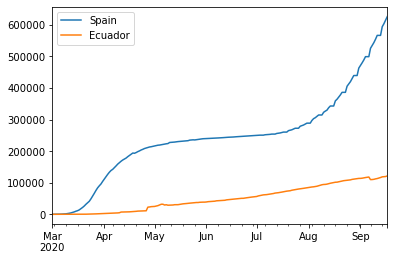

In [62]:
df_res.plot(y=['Spain','Ecuador'])

Detect countries where cases day x is higher compared to cases day x+1:

In [63]:
liste = []
for country in df_res.columns:
    max_v = 0
    temp = df_res[country][0]
    for i in range(1,len(df_res)):
        if df_res[country][i] >= max_v:
            max_v = df_res[country][i]
        else:
            liste.append(country)

In case of duplicates, make list containing only unique elements:

In [64]:
outlier_countries_list = list(set(liste))

Detected outlier countries:

In [65]:
outlier_countries_list

['Spain',
 'Luxembourg',
 'Portugal',
 'Ecuador',
 'Italy',
 'Uganda',
 'Lithuania',
 'France']

Remove outlier countries from dataframe:

In [66]:
df_res.drop(outlier_countries_list, axis=1, inplace=True)

Save dataframe to parquet:

In [67]:
#df_res.to_parquet('../data/pre_processed/data_covid_cases.parquet')

## Data transformation ##

As the difference in number of cases varies very between countries, it is necessary to transform the dataframe to achive a similar scale. Two transformations where tested, z-transform and dividing the infection trend by the population in the respective country. See implementation and comparesent below. For more factual information, see the associated paper. 

### Z-transform ###

Finding mean and standard deviation of each column in the dataframe:

In [68]:
means=df_res.mean(axis=0)
stds=df_res.std(axis=0)

Creating a new copy of the dataframe, replacing each cell with its z-transformed value:

In [69]:
z_df=df_res.copy()
for col in df_res.columns:
    z_df[col]=(df_res[col]-means[col])/stds[col]

Resulting dataframe:

In [70]:
z_df.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,-1.016766,-0.704723,-1.314497,-2.128248,-1.062776,-0.974537,-1.383280,-2.021154,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828760,-1.206989,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-02,-1.016766,-0.704723,-1.314127,-2.127737,-1.062476,-0.974537,-1.383280,-2.020472,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828718,-1.206979,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-03,-1.016766,-0.704723,-1.313633,-2.127226,-1.062476,-0.974537,-1.383280,-2.019753,-0.852664,-0.982762,...,-0.993805,-1.677526,-0.977963,-1.334201,-1.828530,-1.206972,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-04,-1.016640,-0.704717,-1.312644,-2.126459,-1.062375,-0.974537,-1.383176,-2.018465,-0.852664,-0.982762,...,-0.993805,-1.677526,-0.977941,-1.333975,-1.828189,-1.206962,-1.733456,-1.337746,-0.739615,-0.683331


Plot of all countries z-transformed:

Text(0.5, 0, 'Month')

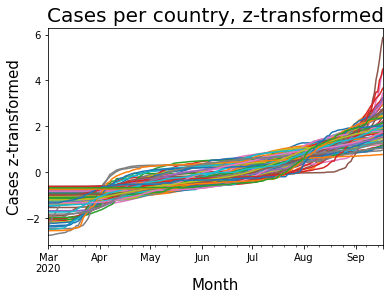

In [87]:
z_df.plot(legend='')
plt.title('Cases per country, z-transformed', fontsize=20)
plt.ylabel('Cases z-transformed', fontsize=15)
plt.xlabel('Month', fontsize=15)

Save dataframe to parquet:

In [72]:
#z_df.to_parquet('../data/pre_processed/covid_cases_z_trans.parquet')

### Cases per population ###

Creating a new copy of the dataframe, dividing each cell with the corresponding population of that country (column name):
<br>
Using extract function to retrive population from lookup table

In [73]:
cases_popu=df_res.copy()
for col in df_res.columns:
    cases_popu[col] = df_res[col].div(extract_func(col,'Population'))

Resulting dataframe:

In [74]:
cases_popu.head(4)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,7.260733e-08,0.000000e+00,0.000001,0.000001,0.000027,0.0,1.051760e-07,8.793475e-08,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.000002,6.361490e-07,2.118389e-07,0.0,1.674677e-07,0.0,0.0
2020-03-02,7.260733e-08,0.000000e+00,0.000001,0.000002,0.000031,0.0,1.051760e-07,1.670760e-06,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.000002,7.118810e-07,2.732415e-07,0.0,1.674677e-07,0.0,0.0
2020-03-03,7.260733e-08,0.000000e+00,0.000001,0.000002,0.000031,0.0,1.051760e-07,3.341521e-06,0.0,0.0,...,8.671427e-08,0.0,0.000000e+00,0.000002,1.045102e-06,3.162233e-07,0.0,1.674677e-07,0.0,0.0
2020-03-04,1.210122e-07,2.258813e-08,0.000002,0.000003,0.000033,0.0,4.207039e-07,6.331302e-06,0.0,0.0,...,8.671427e-08,0.0,2.230591e-08,0.000003,1.650958e-06,3.837662e-07,0.0,1.674677e-07,0.0,0.0


Plot of infection for each country divided by population:

Text(0.5, 0, 'Month')

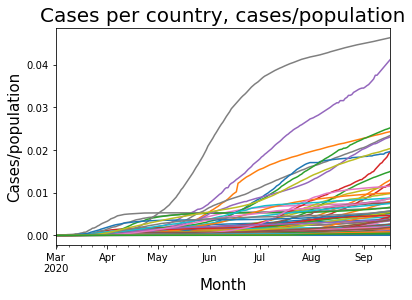

In [86]:
cases_popu.plot(legend='')
plt.title('Cases per country, cases/population', fontsize=20)
plt.ylabel('Cases/population', fontsize=15)
plt.xlabel('Month', fontsize=15)

Save dataframe to parquet:

In [76]:
#cases_popu.to_parquet('../data/pre_processed/cases_per_popu.parquet')

## Comparing the differnet transformations

Text(0.5, 0, 'Month')

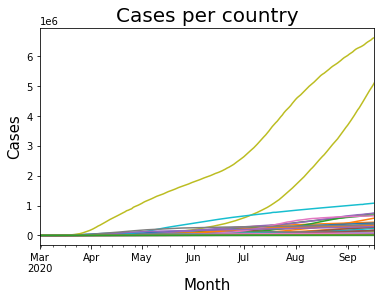

In [85]:
df_res.plot(legend='')
plt.title('Cases per country', fontsize=20)
plt.ylabel('Cases', fontsize=15)
plt.xlabel('Month', fontsize=15)


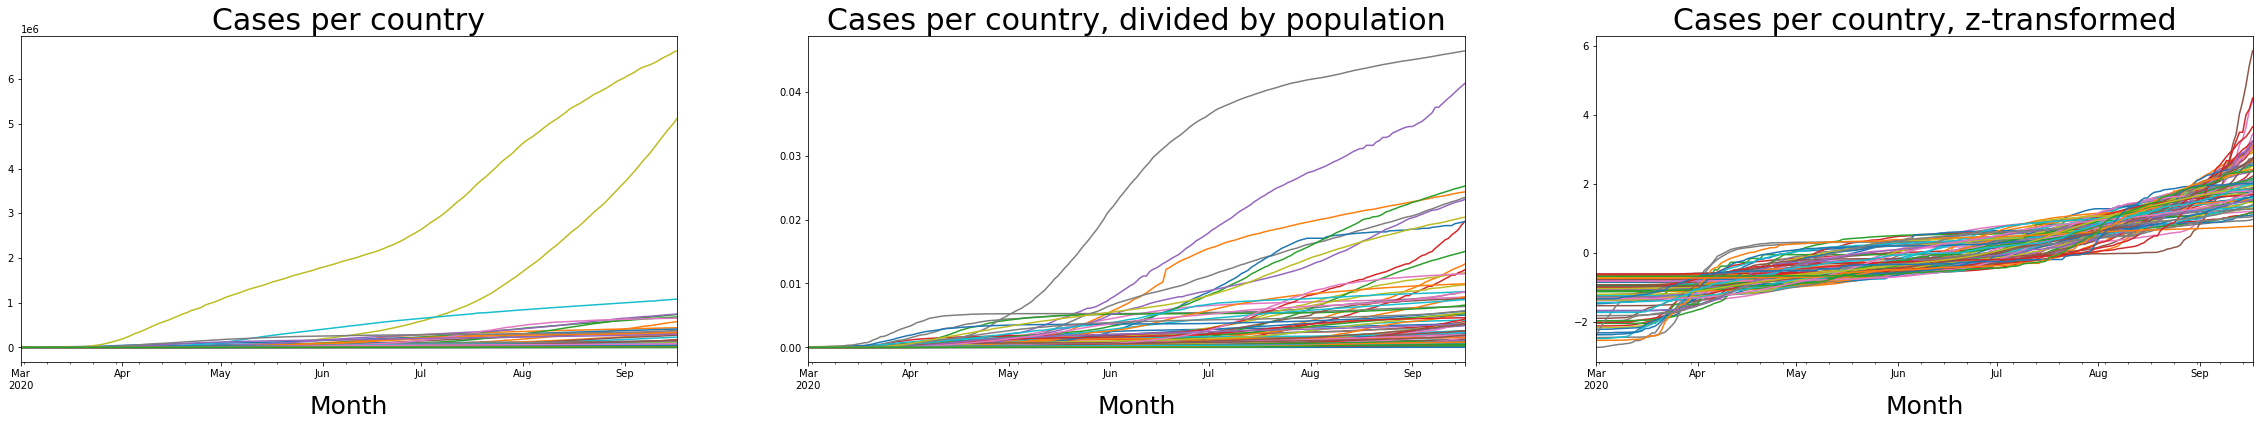

In [77]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(40)


df_res.plot(legend='',ax=axs[0])

cases_popu.plot(legend='', ax=axs[1])

z_df.plot(legend='', ax=axs[2])
axs[0].set_title('Cases per country', fontsize=30)
axs[1].set_title('Cases per country, divided by population', fontsize=30)
axs[2].set_title('Cases per country, z-transformed', fontsize=30)

for ax in axs.flat:
    ax.set_xlabel('Month', fontsize=25)

#plt.savefig("data_formats", bbox_inches='tight')